In [ ]:
#Modules
import numpy as np
import random
import matplotlib.pyplot as plt

#Initialise number of bandits and iterations
n = 8
k = 500


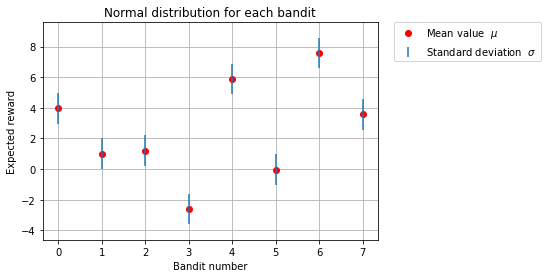

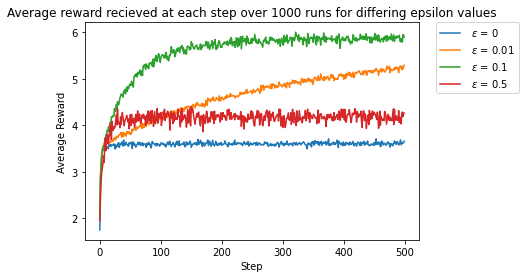

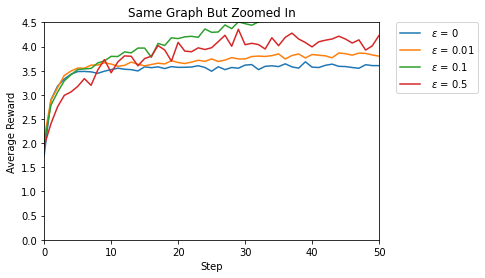

In [ ]:
class MultiArmedBandit():

  def __init__(self, n=10, k=500, e=0.1):

    self.n = n
    self.k = k
    self.e = e
    self.rewards = []
    self.lever_pulls = [0 for i in range(self.n)]

    #Initialise a mean for each bandit, taken from a normal distribution
    self.mean_values = [np.random.normal(2, 3) for i in range(self.n)]

    #Initialise list that keeps track (via index correspondence) of each arms' moving average reward
    self.value_function = [0 for i in range(self.n)]

  def reset(self):
    #Reset the rewards vector and value function for each arm
    self.rewards = []
    self.lever_pulls = [0 for i in range(self.n)]
    self.mean_values = [np.random.normal(2, 3) for i in range(self.n)]
    self.value_function = [0 for i in range(self.n)]

  #Create function that takes a sample each arm's normal distribution, where each arm has a mean corresponding to its index in mean_values, and std 1
  def pull_lever(self, arm):
    return np.random.normal(self.mean_values[arm-1], 1)

  def select(self):
    #Decide whether to explore
    if random.random() < self.e:
      #Choose a random arm to pull
      arm = random.randrange(1, self.n + 1)

    #Otherwise exploit arm with biggest current average reward
    else:
      arm = self.value_function.index(max(self.value_function)) + 1

    return arm

  def play_the_game(self):

    for i in range(1, self.k + 1):

      #Choose a random arm to pull
      arm = self.select()

      reward = self.pull_lever(arm)
      self.lever_pulls[arm-1] += 1

      #Update reward moving average for this arm
      self.value_function[arm-1] += 1/self.lever_pulls[arm-1] * (reward - self.value_function[arm-1])

      self.rewards.append(reward)

    return self.rewards, self.lever_pulls

  def visualise_bandit_distribution(self):
    #Visualise normal disrtibution for each bandit
    plt.plot(np.arange(self.n), self.mean_values, 'ro', label='Mean value $\ \mu$')
    plt.errorbar(np.arange(self.n), self.mean_values, yerr=np.ones(self.n), fmt='none', label='Standard deviation $\ \sigma$')
    plt.grid()
    plt.title('Normal distribution for each bandit')
    plt.ylim(min(self.mean_values)-2, max(self.mean_values)+2)
    plt.xlabel('Bandit number')
    plt.ylabel('Expected reward')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.show()

  def visualise_rewards(self):
    plt.plot([i for i in range(self.k)], self.rewards)
    plt.xlabel("Steps")
    plt.ylabel("Reward")
    plt.show()

  def compare_epsilons(self, epsilon_values, runs=2000):

    self.runs = runs
    self.epsilon_values = epsilon_values

    #Initialise a list that will contain a list for each epsilon. Each of these sublists will be of length k, and will indicate the average
    #reward recieved on the kth step over *runs* number of independent iterations. This should show that certain epsilon values tend to improve, whilst
    #other don't (or improve slower).
    self.average_reward = []
    self.lever_pulls_log=[]

    for e in epsilon_values:
      self.e = e

      #Initialise a zeros vector that will track the average reward for each of the k turns over *runs* iterations
      epsilon_reward = np.zeros((self.k, ))
      lever_pulls=np.zeros((self.n))
      for run in range(runs):

        self.reset()
        eReward,lPulls = self.play_the_game()
        epsilon_reward=np.add(epsilon_reward,eReward)
        lever_pulls=np.add(lever_pulls,lPulls)

      # Average for each turn
      self.average_reward.append(epsilon_reward / runs)
      self.lever_pulls_log.append(lever_pulls / runs)


    return self.average_reward

  def visualise_epsilon_comparison(self):
    plt.figure(0)
    for i in self.epsilon_values:
      plt.plot([i for i in range(self.k)], self.average_reward[self.epsilon_values.index(i)], label='$\ \epsilon$ = %s'%i)
    plt.xlabel("Step")
    plt.ylabel("Average Reward")
    plt.title("Average reward recieved at each step over %s runs for differing epsilon values"%self.runs)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

    #Zoom in
    plt.figure(1)
    for i in self.epsilon_values:
      plt.plot([i for i in range(self.k)], self.average_reward[self.epsilon_values.index(i)], label='$\ \epsilon$ = %s'%i)
    plt.xlabel("Step")
    plt.ylabel("Average Reward")
    plt.title("Same Graph But Zoomed In")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.xlim(0, 50)
    plt.ylim(0, 4.5)
    plt.show()

epsilon_values = [0, 0.01, 0.1, 0.5]

x = MultiArmedBandit(n=n, k=500)
x.play_the_game()
x.visualise_bandit_distribution()

x.compare_epsilons(epsilon_values, runs=1000)
x.visualise_epsilon_comparison()


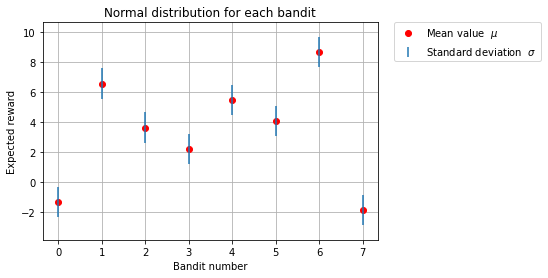

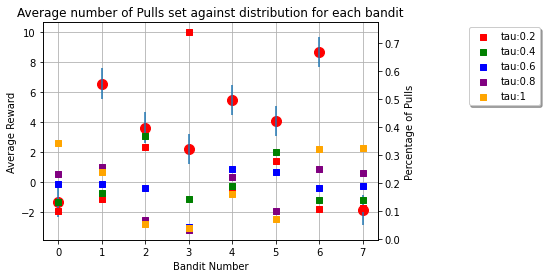

In [ ]:
class Softmax(MultiArmedBandit):
    def __init__(self,n,k, tau=0.5):
        super().__init__(n,k)
        self.e = tau

    def select(self):
        e_x=np.exp(np.array(self.value_function) / self.e)
        probs=np.divide(e_x,e_x.sum())

        result = random.choices([i for i in range(1,self.n+1)],probs,k=1)[0]


        return result
    def reset(self):
    #Reset the rewards vector and value function for each arm
        self.rewards = []
        self.lever_pulls = [0 for i in range(self.n)]
        self.value_function = [0 for i in range(self.n)]

    def visualise_tau(self,tau_values):
        fig, ax1 = plt.subplots()
        ax1.plot(np.arange(self.n), self.mean_values, 'ro',markersize=10)
        ax1.errorbar(np.arange(self.n), self.mean_values, yerr=np.ones(self.n), fmt='none')
        ax1.grid()
        ax1.set_xlabel('Bandit Number')
        ax1.set_ylabel('Average Reward')
        ax1.tick_params(axis='y')
        ax1.set_ylim(min(self.mean_values)-2, max(self.mean_values)+2)
        plt.title('Average number of Pulls set against distribution for each bandit')
        ax2 = ax1.twinx()
        colors = ['red', 'green', 'blue', 'purple','orange']
        # Plot each set of data points with its corresponding color
        for i in range(len(self.lever_pulls_log)):
            x_values = range(len(self.lever_pulls_log[i]))
            y_values = self.lever_pulls_log[i]
            color = colors[i]
            name = f'tau:{tau_values[i]}'
            ax2.scatter(x_values, y_values, color=color,label=name,marker='s')

        # Set the x and y axis labels
        plt.xlabel('Bandit Number')
        plt.ylabel('Percentage of Pulls')
        plt.legend(bbox_to_anchor=(1.5, 1),fancybox=True,shadow=True)

        # Show the plot
        plt.show()



tau_values=[0.2,0.4,0.6,0.8,1]
y = Softmax(n=n, k=250)
y.play_the_game()
y.visualise_bandit_distribution()

y.compare_epsilons(tau_values, runs=2000)
y.visualise_tau(tau_values)

